In [1]:
#GammaSpec_fit_Ec.py
"""
GammaStack Image processing and spectrum fitting for Compton data,
handles one shot at a time.
"""

import os, sys
sys.path.append('../../')
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import least_squares, leastsq
from scipy.special import kv, kn, expi
from scipy.constants import e, c, epsilon_0, m_e, Boltzmann, hbar, Planck
import math
import matplotlib
import matplotlib.pyplot as plt
#import cv2
#import emcee
#import corner
from scipy.ndimage import median_filter, rotate
from scipy.io import loadmat
from skimage.io import imread

from setup import *
from lib.general_tools import *
from lib.pipeline import *
from modules.GammaSpec.GammaSpecProc import *

np.random.seed(10)

0.69897
3.0
(996, 15)
N_crystals_X = 14, N_crystals_Y = 8


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


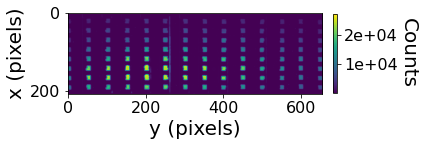

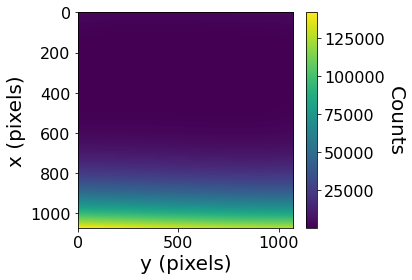

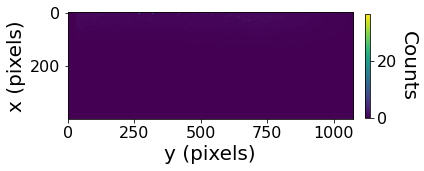

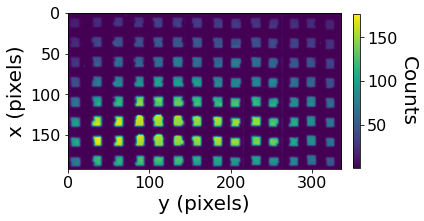

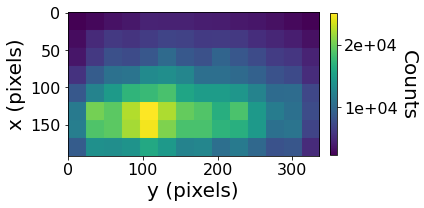

In [2]:
diag='CsIStackTop'#'CsIStackTop'#'CsIStackTop'#'CsIStackSide'
date='20210608'
run='run10'
shot='Shot029'

# date='20210620'
# run='run12'
# shot='Shot041'

pathT=ROOT_DATA_FOLDER+diag+'/'+date+'/'+run+'/'+shot+'.tif'
GammaStack_Img=imread(pathT)

#load crystal properties from mat file
coords, N_crystals_X, N_crystals_Y, pos_array_X, pos_array_Y, crystal_size_XY_pxl, rot_deg=load_crystal_properties(diag)
#load energy deposition info from mat file
Egamma_MeV_interp, CsIEnergy_ProjZ_interp=load_Edep_info(diag)
#load correction factor for CsI stack
corr_factor_mean, corr_factor_se=load_correction_factor(diag)#diag)
# corr_factor_mean_Top, corr_factor_se=load_correction_factor('CsIStackTop')#diag)
# corr_factor_mean_Side, corr_factor_se=load_correction_factor('CsIStackSide')#diag)

# plt.plot(np.arange(len(corr_factor_mean_Top)), corr_factor_mean_Top)
# plt.plot(np.arange(len(corr_factor_mean_Side)), corr_factor_mean_Side)
# plt.show()

CsIStack=GammaStack(coords, N_crystals_X, N_crystals_Y, pos_array_X, pos_array_Y, crystal_size_XY_pxl, rot_deg, Egamma_MeV_interp, CsIEnergy_ProjZ_interp, corr_factor_mean, corr_factor_se, kernel=3, debug=True)
#CsIStack.plot_contours(GammaStack_Img)
print("N_crystals_X = %s, N_crystals_Y = %s"%(N_crystals_X, N_crystals_Y))

measured_signal_summed_over_columns=CsIStack.get_measured_signal_summed_over_columns(GammaStack_Img)#, get_total_counts=False, get_beam_pointing=False)


In [3]:
# random number to normalise by
norm_Ec=np.random.uniform(1.0, 100.0)
#least squares fitting routine
guess=[23.0, 1.0, 0.5]#,0.197, 0.803]
popt, pcov=CsIStack.least_sqrs(CsIStack.calc_theoretical_Compton_signal_summed_over_columns, guess, measured_signal_summed_over_columns)
popt_norm=popt/norm_Ec
pcov_norm=pcov/norm_Ec
print('Ec=%s, sigma Ec=%s'%(popt_norm, pcov_norm))

Gamma_energy_spec=CsIStack.calc_Compton_energy_spec(popt[0], popt[1], popt[2])

# E_axis_test=np.linspace(5.0, 1000, 500)
# spec_test=E_axis_test**-(2.0/3.0)*np.exp(-E_axis_test/guess[0])
# E=CsIStack.Egamma_MeV_interp[0]
# print(E**-(2.0/3.0)*np.exp(-E/guess[0]))

Ec=[1.29836279e-01 1.53128138e+01 8.07321102e-03], sigma Ec=[1.59377966e-01 2.52904154e+07 1.33335968e+04]


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


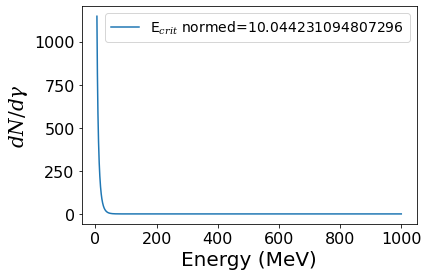

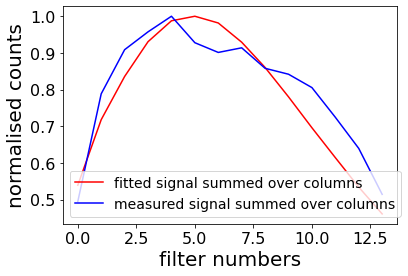

In [4]:
#
#plt.plot(E_axis_test, spec_test, label='E$_{crit}=%s$'%(guess[0]))
plt.plot(CsIStack.Egamma_MeV_interp, Gamma_energy_spec, label='E$_{crit}$ normed=%s'%(popt[0]))
plt.xlabel('Energy (MeV)')
plt.ylabel('$dN/d\gamma$')
plt.legend()
plt.show()

#predicted_signal_summed_over_columns=CsIStack.calc_theoretical_Compton_signal_summed_over_columns(None, guess[0], )#, guess[1], guess[2])
fitted_signal_summed_over_columns=CsIStack.calc_theoretical_Compton_signal_summed_over_columns(None, popt[0], popt[1], popt[2])#, guess[1], guess[2])

filter_nos=np.arange(CsIStack.N_crystals_X_cutoff)
plt.plot(filter_nos, fitted_signal_summed_over_columns, color='r', label='fitted signal summed over columns')
plt.plot(filter_nos, measured_signal_summed_over_columns, color='b',label='measured signal summed over columns')
plt.xlabel('filter numbers')
plt.ylabel('normalised counts')
plt.legend()
plt.show()

In [5]:
'''
# Brems fitting??? Unfinished
guess=[23.0, 0.197, 1.0]
popt, pcov=CsIStack.least_sqrs(CsIStack.calc_theoretical_Brems_signal_summed_over_columns, guess, measured_signal_summed_over_columns)
print('Ec=%s, sigma Ec=%s'%(popt, pcov))
print(popt[1])

Gamma_energy_spec=CsIStack.calc_Brems_energy_spec(popt[0], popt[1])

# E_axis_test=np.linspace(5.0, 1000, 500)
# spec_test=E_axis_test**-(2.0/3.0)*np.exp(-E_axis_test/guess[0])
# E=CsIStack.Egamma_MeV_interp[0]
# print(E**-(2.0/3.0)*np.exp(-E/guess[0]))

# plt.plot(E_axis_test, spec_test, label='E$_{crit}=%s$'%(guess[0]))
plt.plot(CsIStack.Egamma_MeV_interp, Gamma_energy_spec, label='E$_{crit}=%s$'%(popt[0]))
plt.xlabel('Energy (MeV)')
plt.ylabel('$dN/d\gamma$')
plt.legend()
plt.show()

#predicted_signal_summed_over_columns=CsIStack.calc_theoretical_Brems_signal_summed_over_columns(None, guess[0], guess[1], guess[2])
predicted_signal_summed_over_columns=CsIStack.calc_theoretical_Brems_signal_summed_over_columns(None, popt[0], popt[1], popt[2])
filter_nos=np.linspace(1, CsIStack.N_crystals_X, CsIStack.N_crystals_X)

plt.plot(filter_nos, predicted_signal_summed_over_columns, color='r')
plt.plot(filter_nos, measured_signal_summed_over_columns, color='b')
plt.xlabel('filter numbers')
plt.ylabel('normalised counts')
plt.show()'''

"\n# Brems fitting??? Unfinished\nguess=[23.0, 0.197, 1.0]\npopt, pcov=CsIStack.least_sqrs(CsIStack.calc_theoretical_Brems_signal_summed_over_columns, guess, measured_signal_summed_over_columns)\nprint('Ec=%s, sigma Ec=%s'%(popt, pcov))\nprint(popt[1])\n\nGamma_energy_spec=CsIStack.calc_Brems_energy_spec(popt[0], popt[1])\n\n# E_axis_test=np.linspace(5.0, 1000, 500)\n# spec_test=E_axis_test**-(2.0/3.0)*np.exp(-E_axis_test/guess[0])\n# E=CsIStack.Egamma_MeV_interp[0]\n# print(E**-(2.0/3.0)*np.exp(-E/guess[0]))\n\n# plt.plot(E_axis_test, spec_test, label='E$_{crit}=%s$'%(guess[0]))\nplt.plot(CsIStack.Egamma_MeV_interp, Gamma_energy_spec, label='E$_{crit}=%s$'%(popt[0]))\nplt.xlabel('Energy (MeV)')\nplt.ylabel('$dN/d\\gamma$')\nplt.legend()\nplt.show()\n\n#predicted_signal_summed_over_columns=CsIStack.calc_theoretical_Brems_signal_summed_over_columns(None, guess[0], guess[1], guess[2])\npredicted_signal_summed_over_columns=CsIStack.calc_theoretical_Brems_signal_summed_over_columns(None, p